# Departamento de vendas

- Base de dados: https://www.kaggle.com/c/rossmann-store-sales/data

## Importação das bibliotecas e base de dados

In [7]:
!pip install prophet

  Using cached prophet-1.1.2-py3-none-win_amd64.whl (12.1 MB)
  Using cached cmdstanpy-1.1.0-py3-none-any.whl (83 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl (18 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl (47 kB)
  Using cached holidays-0.19-py3-none-any.whl (208 kB)
  Using cached tqdm-4.64.1-py2.py3-none-any.whl (78 kB)
  Using cached hijri_converter-2.2.4-py3-none-any.whl (14 kB)
  Using cached ephem-4.1.4.tar.gz (1.3 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for ephem: started
  Running setup.py install for ephem: finished with status 'error'


  DEPRECATION: ephem is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  error: subprocess-exited-with-error
  
  Running setup.py install for ephem did not run successfully.
  exit code: 1
  
  [73 lines of output]
  running install
  C:\Users\nicol\AppData\Local\Programs\Python\Python311\Lib\site-packages\setuptools\command\install.py:34: SetuptoolsDeprecationWarning: setup.py install is deprecated. Use build and pip and other standards-based tools.
    warnings.warn(
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-311
  creating build\lib.win-amd64-cpython-311\ephem
  copying ephem\cities.py -> build\lib.win-amd64-cpython-311\ephem
  copying ephem\stars.py -> build\lib.wi

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from scipy.stats import norm
from sklearn import metrics
from prophet.diagnostics import cross_validation
from prophet import Prophet

### Dados das vendas

In [2]:
sales_train_df = pd.read_csv('train.csv')

C:\Users\nicol\AppData\Local\Temp\ipykernel_3240\1244316221.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  sales_train_df = pd.read_csv('train.csv')


In [3]:
sales_train_df.shape

(1017209, 9)

In [4]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [5]:
sales_train_df['DayOfWeek'].unique()

array([5, 4, 3, 2, 1, 7, 6], dtype=int64)

In [6]:
sales_train_df['Open'].unique()

array([1, 0], dtype=int64)

In [7]:
sales_train_df['Promo'].unique()

array([1, 0], dtype=int64)

In [8]:
sales_train_df['StateHoliday'].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [9]:
sales_train_df['SchoolHoliday'].unique()

array([1, 0], dtype=int64)

In [10]:
sales_train_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
1017204,1111,2,2013-01-01,0,0,0,0,a,1
1017205,1112,2,2013-01-01,0,0,0,0,a,1
1017206,1113,2,2013-01-01,0,0,0,0,a,1
1017207,1114,2,2013-01-01,0,0,0,0,a,1
1017208,1115,2,2013-01-01,0,0,0,0,a,1


In [11]:
sales_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [12]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


### Dados das lojas

In [13]:
store_info_df = pd.read_csv('store.csv')

In [14]:
store_info_df.shape

(1115, 10)

In [15]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [16]:
store_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [17]:
store_info_df.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


## Exploração dos dados

### Dados das vendas

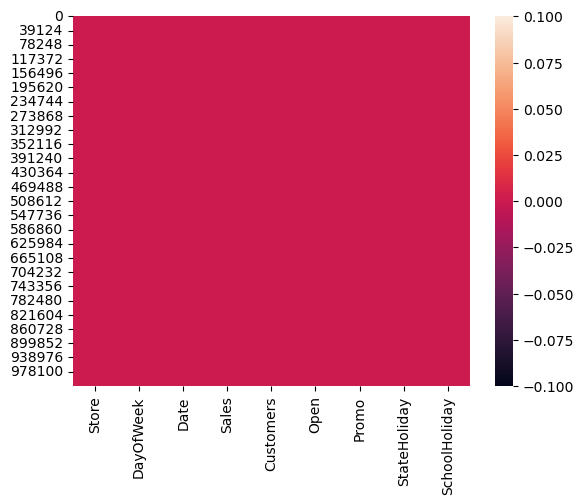

In [18]:
sns.heatmap(sales_train_df.isnull());

In [19]:
sales_train_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'DayOfWeek'}>,
        <AxesSubplot:title={'center':'Sales'}>],
       [<AxesSubplot:title={'center':'Customers'}>,
        <AxesSubplot:title={'center':'Open'}>,
        <AxesSubplot:title={'center':'Promo'}>],
       [<AxesSubplot:title={'center':'SchoolHoliday'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

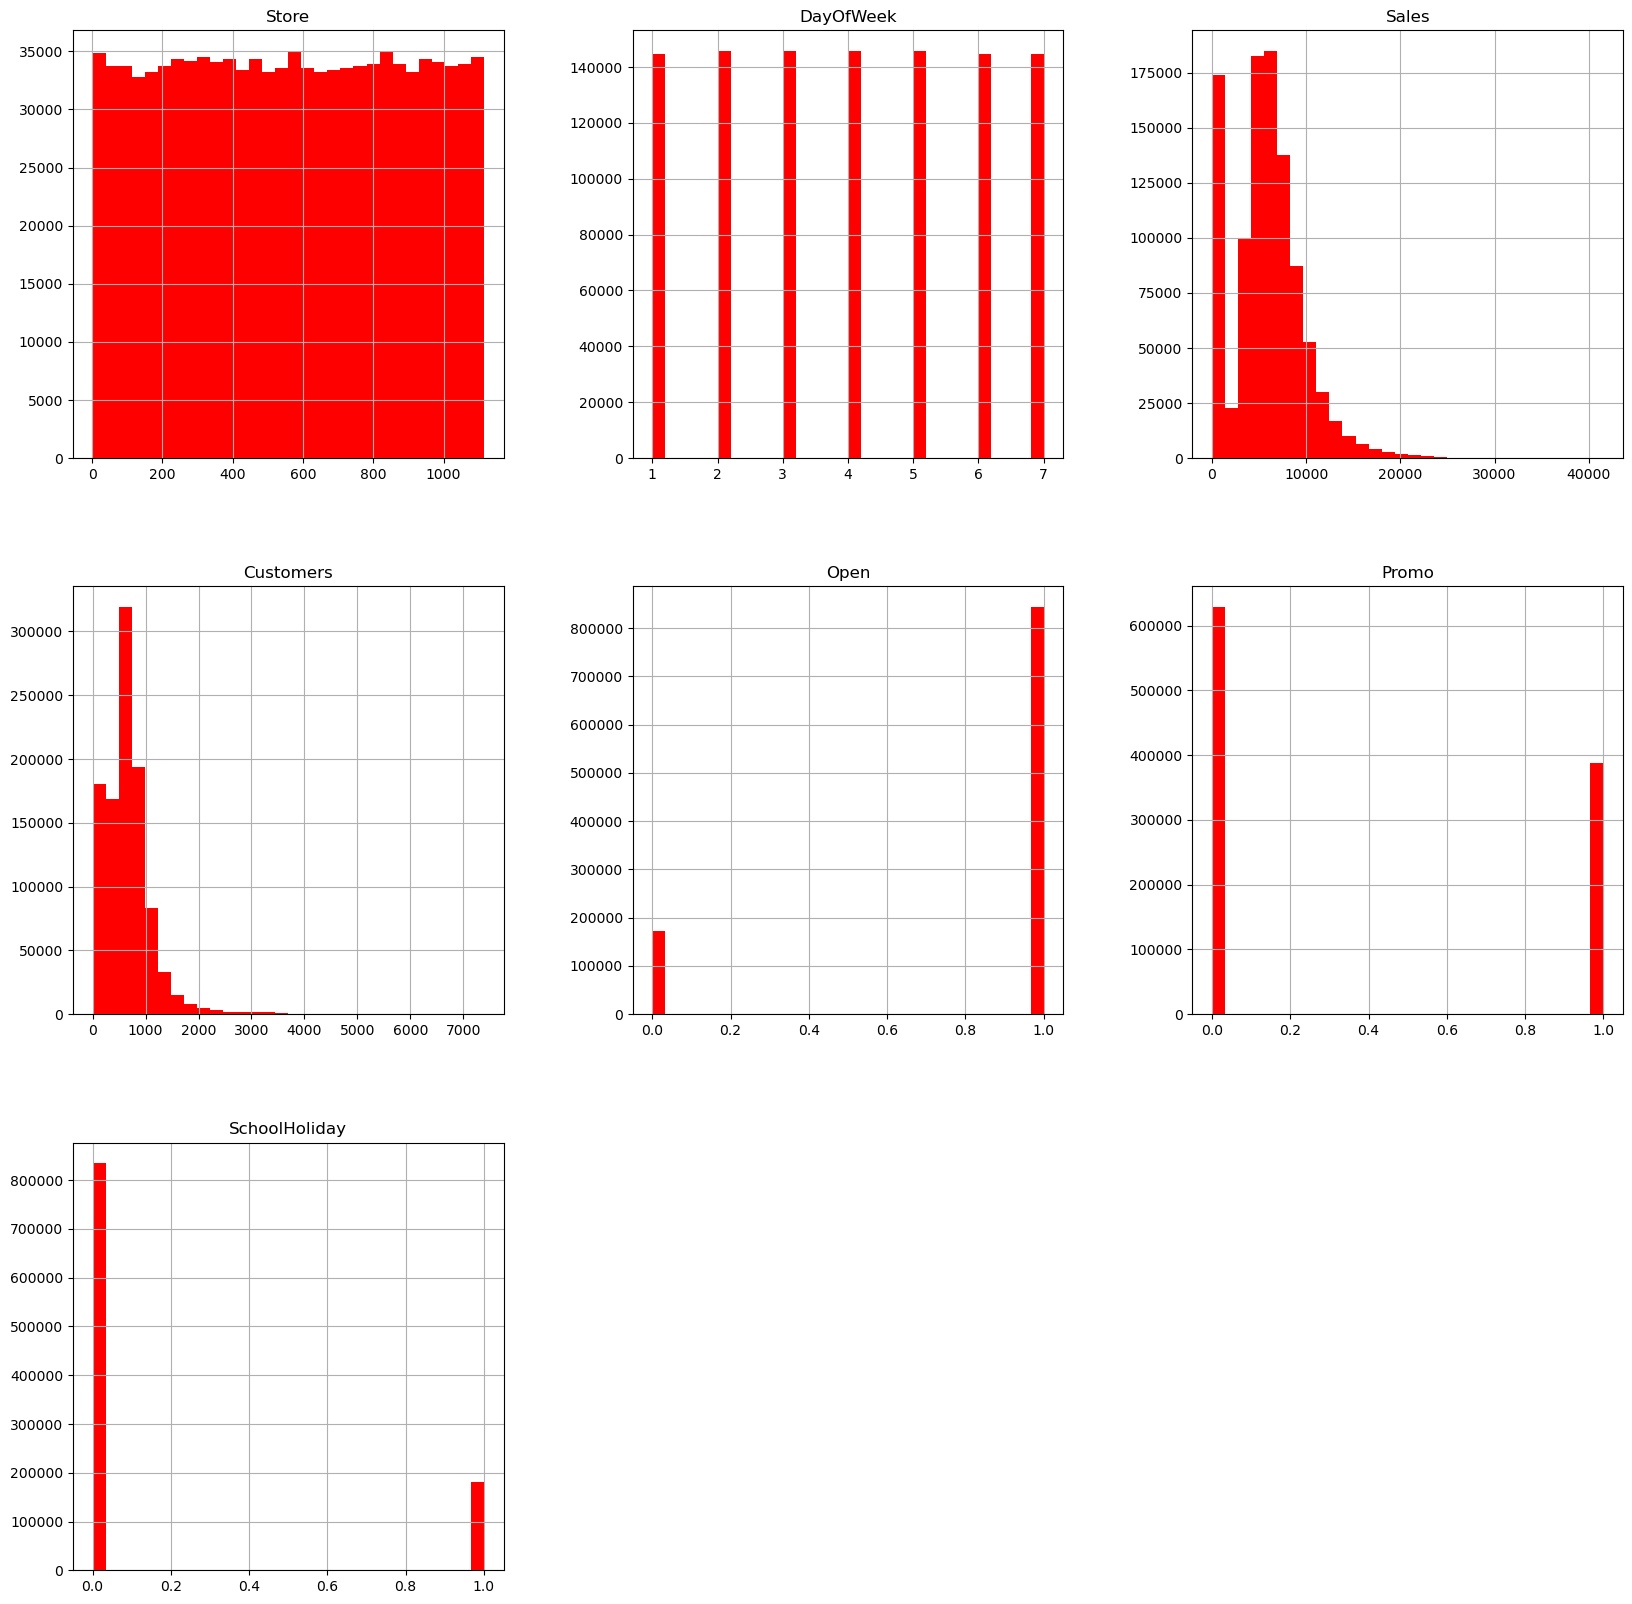

In [20]:
sales_train_df.hist(bins = 30, figsize=(20, 20), color = 'r')

In [21]:
sales_train_df['Customers'].max()

7388

In [22]:
closed_train_df = sales_train_df[sales_train_df['Open'] == 0]
open_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [23]:
print('Total = ', len(sales_train_df))
print('Número de lojas/dias fechado = ', len(closed_train_df))
print('Número de lojas/dias aberto = ', len(open_train_df))

Total =  1017209
Número de lojas/dias fechado =  172817
Número de lojas/dias aberto =  844392


In [24]:
172817 / len(store_info_df)

154.99282511210762

In [25]:
closed_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
291,292,5,2015-07-31,0,0,0,1,0,1
875,876,5,2015-07-31,0,0,0,1,0,1
1406,292,4,2015-07-30,0,0,0,1,0,1
1990,876,4,2015-07-30,0,0,0,1,0,1
2521,292,3,2015-07-29,0,0,0,1,0,1


In [26]:
sales_train_df = sales_train_df[sales_train_df['Open'] == 1]

In [27]:
sales_train_df.shape

(844392, 9)

In [28]:
sales_train_df

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1
...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,566,1,0,a,1
1016827,733,2,2013-01-01,10765,2377,1,0,a,1
1016863,769,2,2013-01-01,5035,1248,1,0,a,1
1017042,948,2,2013-01-01,4491,1039,1,0,a,1


In [29]:
sales_train_df.drop(['Open'], axis = 1, inplace=True)

In [30]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [31]:
sales_train_df.describe()

,Store,DayOfWeek,Sales,Customers,Promo,SchoolHoliday
count,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000,844392.000000
mean,558.422920,3.520361,6955.514291,762.728395,0.446352,0.193580
std,321.731914,1.723689,3104.214680,401.227674,0.497114,0.395103
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,280.000000,2.000000,4859.000000,519.000000,0.000000,0.000000
50%,558.000000,3.000000,6369.000000,676.000000,0.000000,0.000000
75%,837.000000,5.000000,8360.000000,893.000000,1.000000,0.000000
max,1115.000000,7.000000,41551.000000,7388.000000,1.000000,1.000000


### Dados das lojas

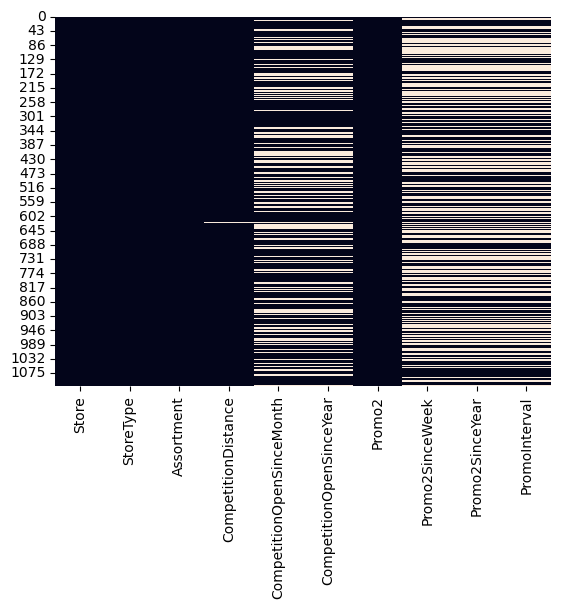

In [32]:
sns.heatmap(store_info_df.isnull(), cbar=False);

In [33]:
store_info_df[store_info_df['CompetitionDistance'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
290,291,d,a,NaN,NaN,NaN,0,NaN,NaN,NaN
621,622,a,c,NaN,NaN,NaN,0,NaN,NaN,NaN
878,879,d,a,NaN,NaN,NaN,1,5.0,2013.0,"Feb,May,Aug,Nov"


In [34]:
store_info_df[store_info_df['CompetitionOpenSinceMonth'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [35]:
store_info_df[store_info_df['CompetitionOpenSinceYear'].isnull()]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
11,12,a,c,1070.0,NaN,NaN,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
12,13,d,a,310.0,NaN,NaN,1,45.0,2009.0,"Feb,May,Aug,Nov"
15,16,a,c,3270.0,NaN,NaN,0,NaN,NaN,NaN
18,19,a,c,3240.0,NaN,NaN,1,22.0,2011.0,"Mar,Jun,Sept,Dec"
21,22,a,a,1040.0,NaN,NaN,1,22.0,2012.0,"Jan,Apr,Jul,Oct"
...,...,...,...,...,...,...,...,...,...,...
1095,1096,a,c,1130.0,NaN,NaN,1,10.0,2014.0,"Mar,Jun,Sept,Dec"
1099,1100,a,a,540.0,NaN,NaN,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1113,1114,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [36]:
store_info_df[store_info_df['Promo2'] == 0]

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
5,6,a,a,310.0,12.0,2013.0,0,NaN,NaN,NaN
6,7,a,c,24000.0,4.0,2013.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
1107,1108,a,a,540.0,4.0,2004.0,0,NaN,NaN,NaN
1109,1110,c,c,900.0,9.0,2010.0,0,NaN,NaN,NaN
1111,1112,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1112,1113,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN


In [37]:
str_cols = ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval',
            'CompetitionOpenSinceYear', 'CompetitionOpenSinceMonth']
for str in str_cols:
  store_info_df[str].fillna(0, inplace=True)

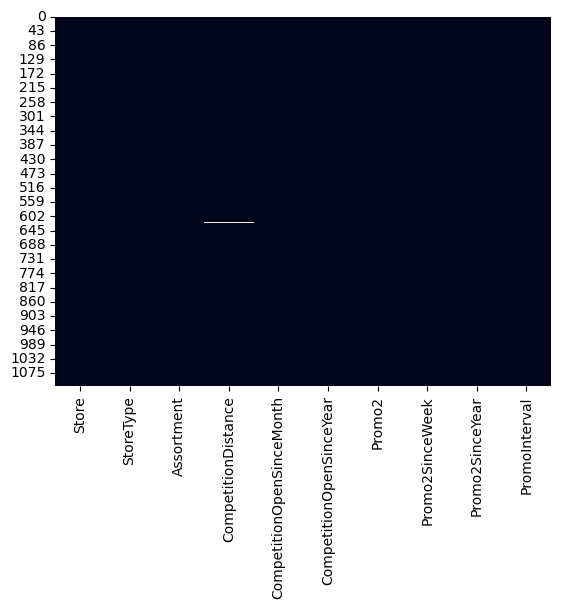

In [38]:
sns.heatmap(store_info_df.isnull(), cbar = False);

In [39]:
store_info_df['CompetitionDistance'].fillna(store_info_df['CompetitionDistance'].mean(), inplace = True)

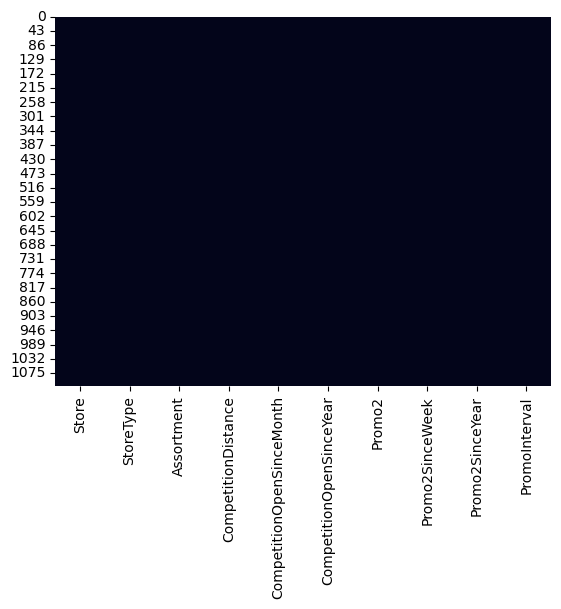

In [40]:
sns.heatmap(store_info_df.isnull(), cbar = False);

array([[<AxesSubplot:title={'center':'Store'}>,
        <AxesSubplot:title={'center':'CompetitionDistance'}>,
        <AxesSubplot:title={'center':'CompetitionOpenSinceMonth'}>],
       [<AxesSubplot:title={'center':'CompetitionOpenSinceYear'}>,
        <AxesSubplot:title={'center':'Promo2'}>,
        <AxesSubplot:title={'center':'Promo2SinceWeek'}>],
       [<AxesSubplot:title={'center':'Promo2SinceYear'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

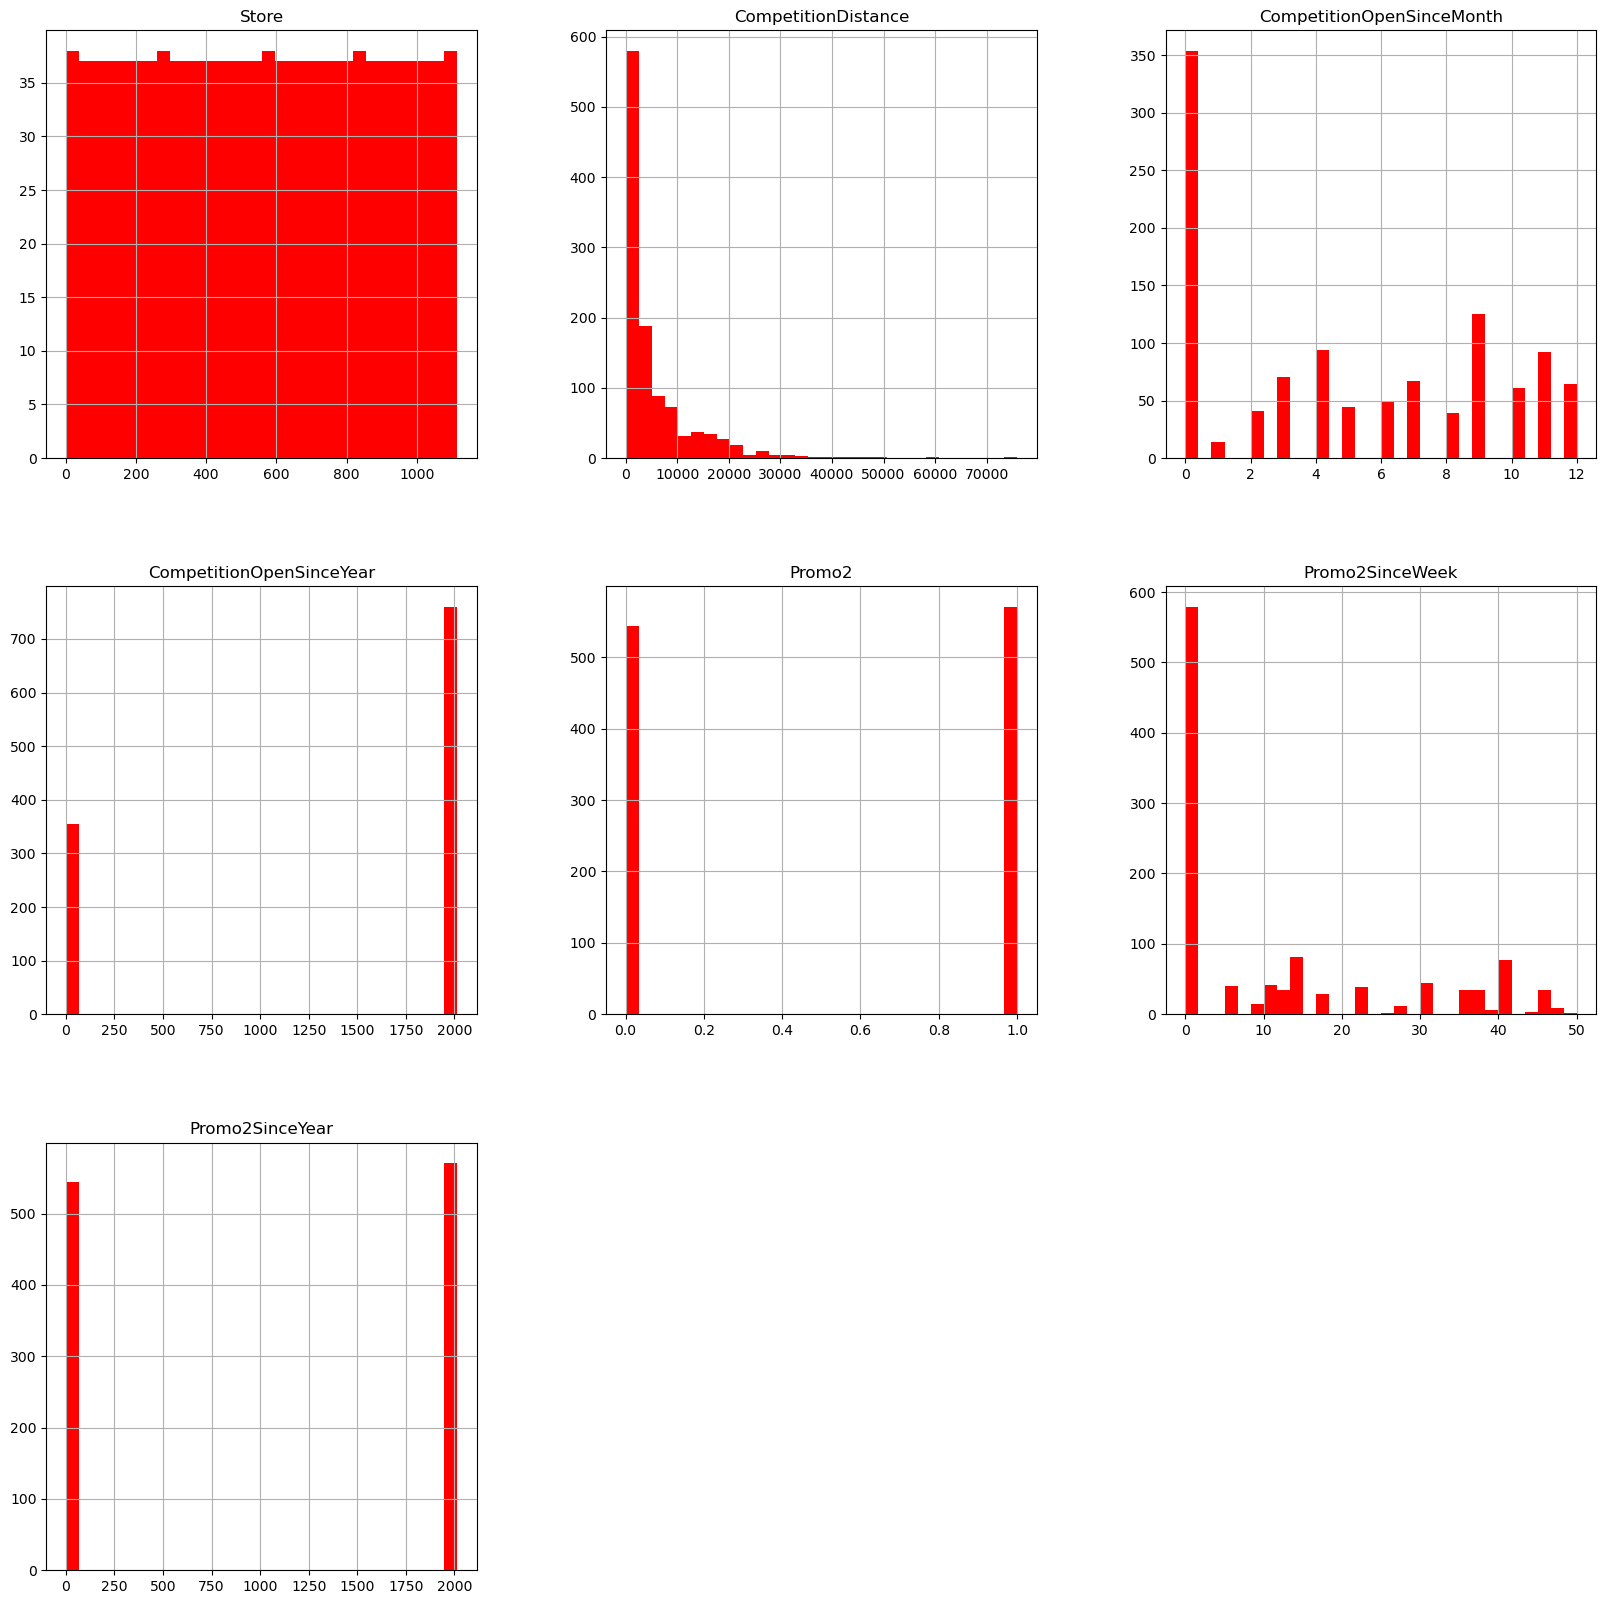

In [41]:
store_info_df.hist(bins = 30, figsize=(20,20), color = 'r')

### Dados unidos (vendas + lojas)

In [42]:
sales_train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,0,1
1,2,5,2015-07-31,6064,625,1,0,1
2,3,5,2015-07-31,8314,821,1,0,1
3,4,5,2015-07-31,13995,1498,1,0,1
4,5,5,2015-07-31,4822,559,1,0,1


In [43]:
store_info_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,0.0,0.0,0
4,5,a,a,29910.0,4.0,2015.0,0,0.0,0.0,0


In [44]:
sales_train_all_df = pd.merge(sales_train_df, store_info_df, how = 'inner', on = 'Store')

In [45]:
sales_train_all_df.shape

(844392, 17)

In [46]:
sales_train_all_df.tail()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0
844391,292,3,2013-01-02,5076,672,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0


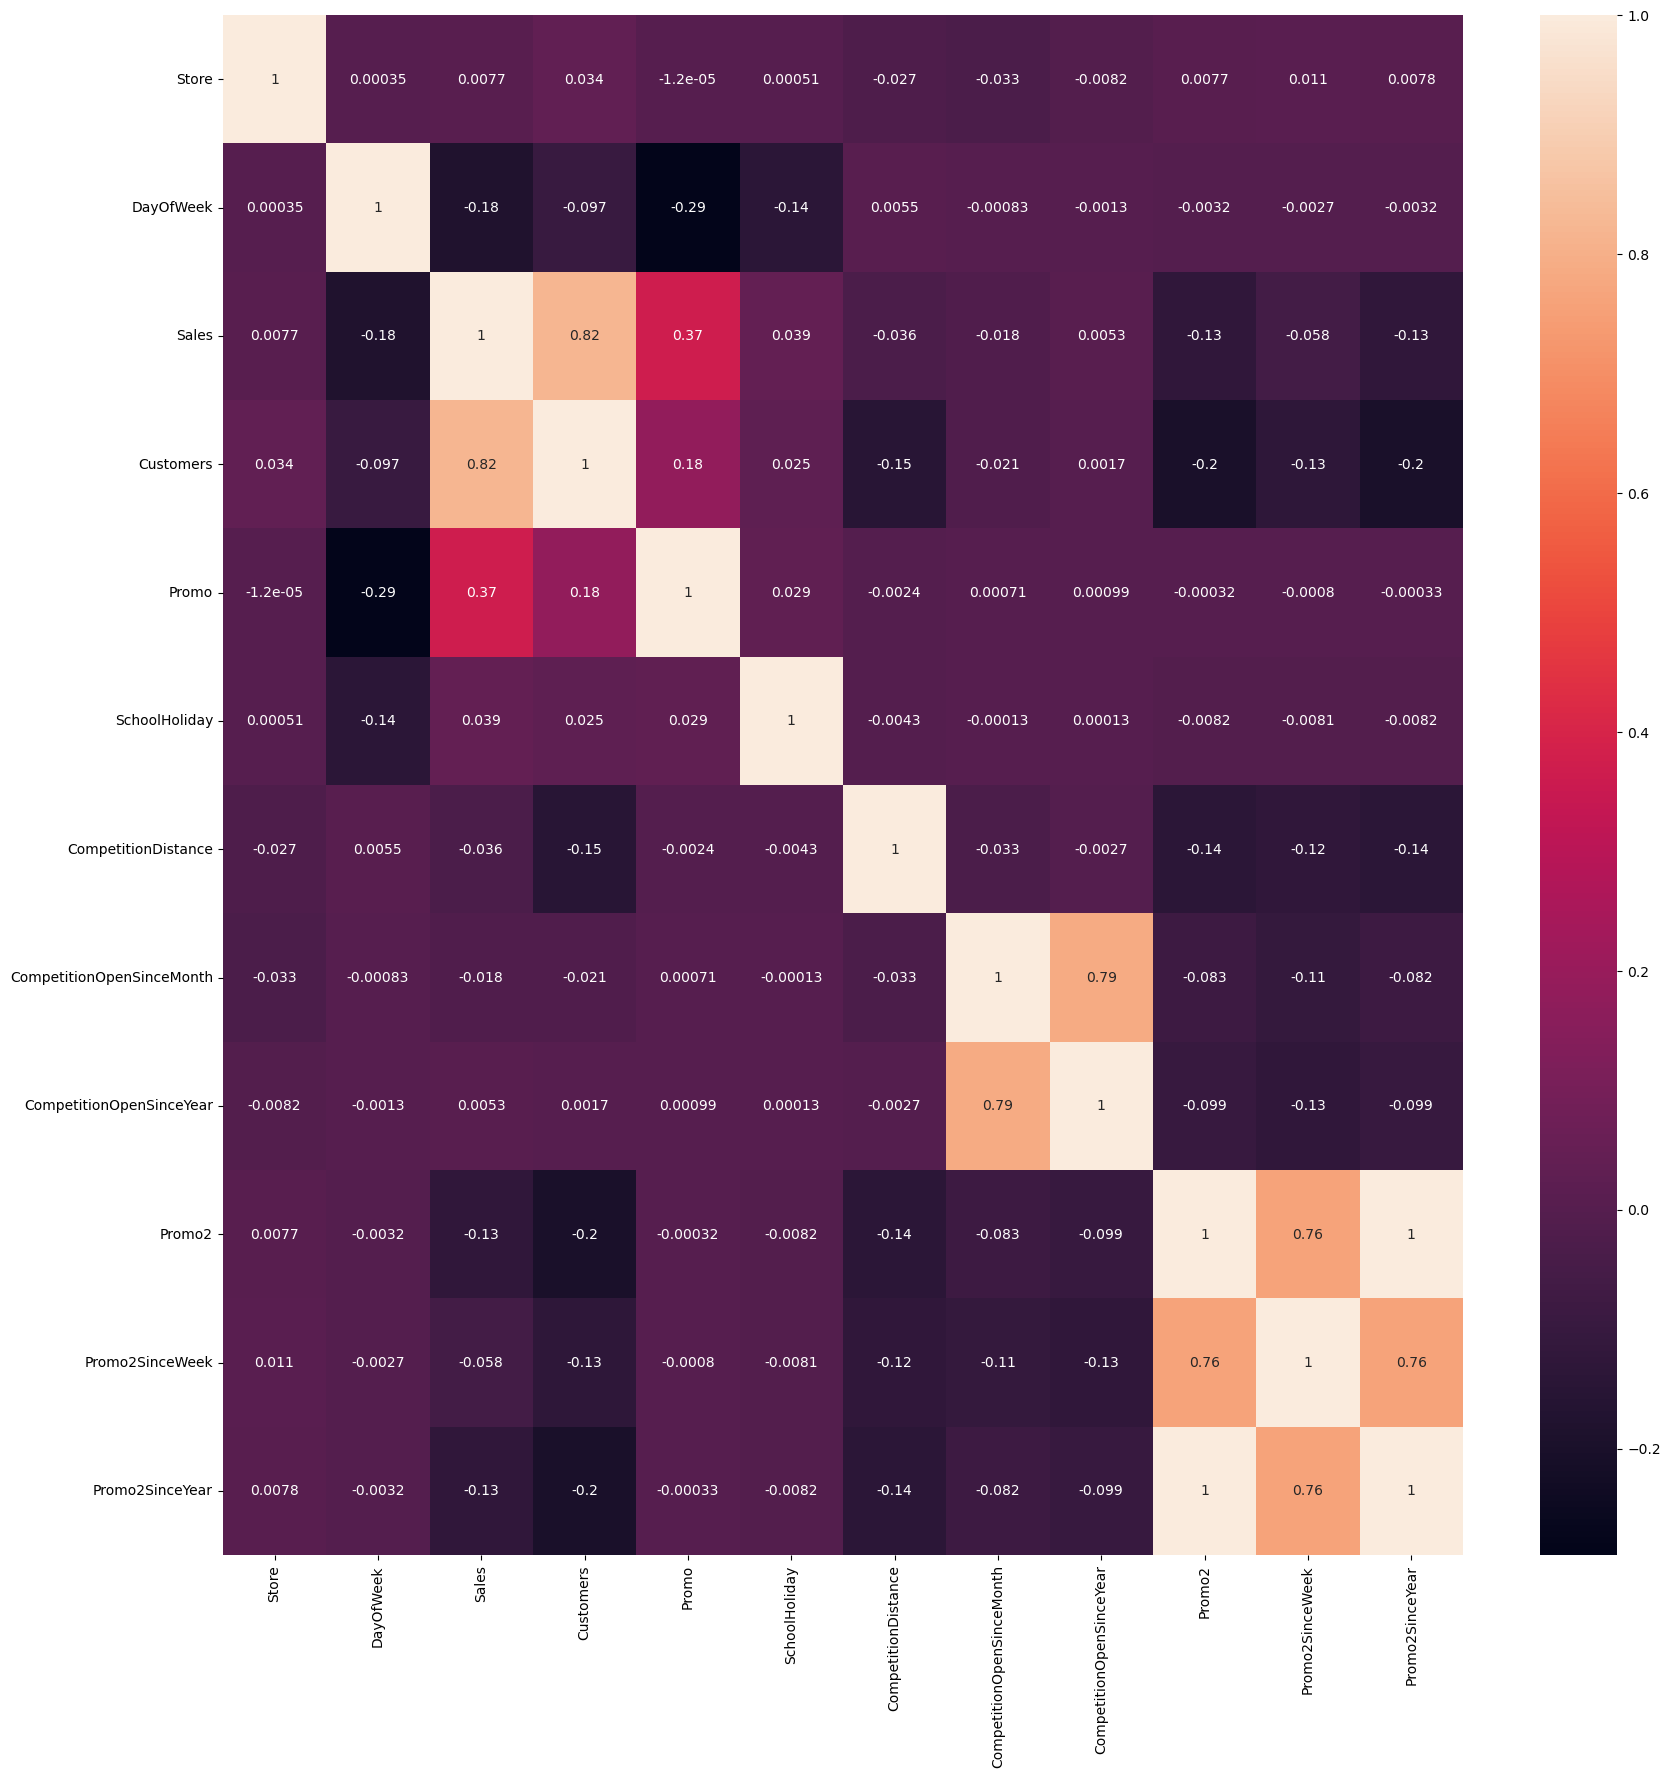

In [47]:
correlations = sales_train_all_df.corr()
f, ax = plt.subplots(figsize=(20,20))
sns.heatmap(correlations, annot = True);

In [48]:
correlations = sales_train_all_df.corr()['Sales'].sort_values()
correlations

DayOfWeek                   -0.178736
Promo2SinceYear             -0.127621
Promo2                      -0.127596
Promo2SinceWeek             -0.058476
CompetitionDistance         -0.036343
CompetitionOpenSinceMonth   -0.018370
CompetitionOpenSinceYear     0.005266
Store                        0.007710
SchoolHoliday                0.038617
Promo                        0.368145
Customers                    0.823597
Sales                        1.000000
Name: Sales, dtype: float64

In [49]:
sales_train_all_df['Year'] = pd.DatetimeIndex(sales_train_all_df['Date']).year

In [50]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015


In [51]:
sales_train_all_df['Month'] = pd.DatetimeIndex(sales_train_all_df['Date']).month
sales_train_all_df['Day'] = pd.DatetimeIndex(sales_train_all_df['Date']).day

In [52]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


Text(0.5, 1.0, 'Média de vendas por mês')

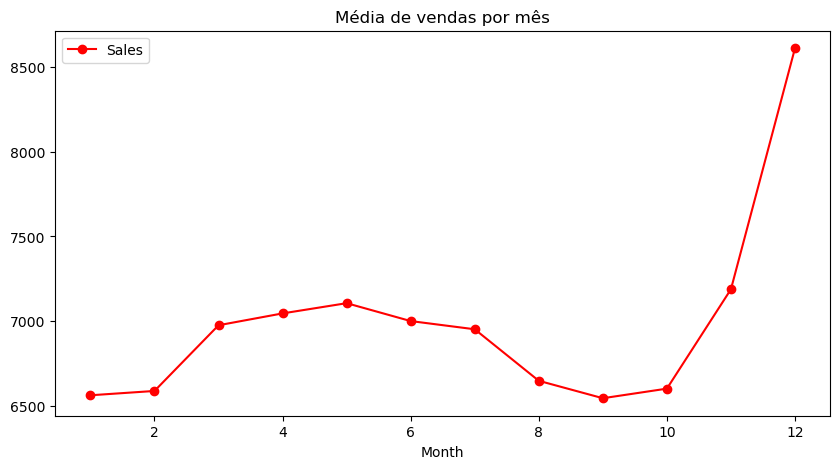

In [53]:
axis = sales_train_all_df.groupby('Month')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Média de vendas por mês')

Text(0.5, 1.0, 'Média de clientes por mês')

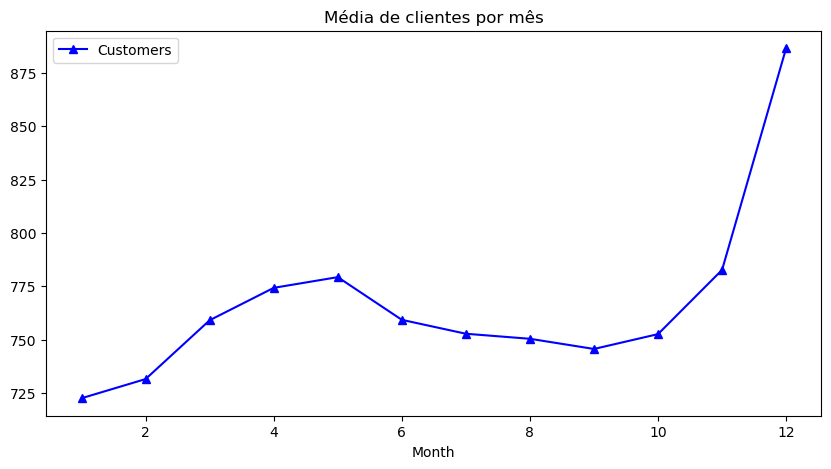

In [54]:
axis = sales_train_all_df.groupby('Month')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Média de clientes por mês')

Text(0.5, 1.0, 'Média de vendas por dia')

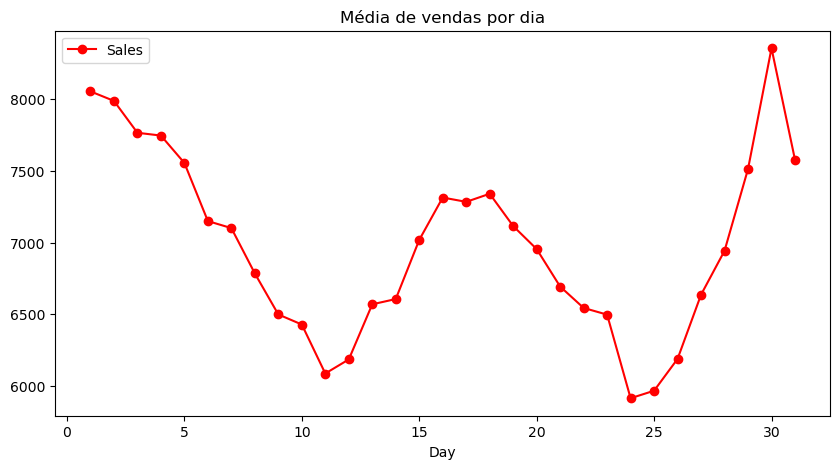

In [55]:
axis = sales_train_all_df.groupby('Day')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Média de vendas por dia')

Text(0.5, 1.0, 'Média de clientes por dia')

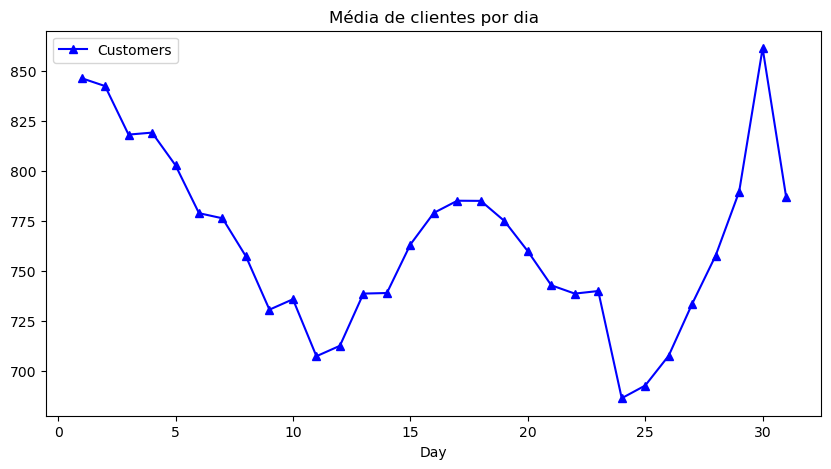

In [56]:
axis = sales_train_all_df.groupby('Day')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Média de clientes por dia')

Text(0.5, 1.0, 'Média de vendas por dia da semana')

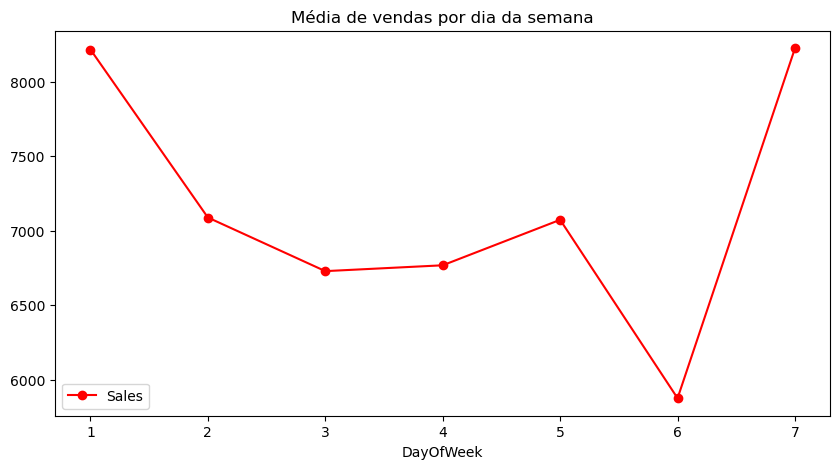

In [57]:
axis = sales_train_all_df.groupby('DayOfWeek')[['Sales']].mean().plot(figsize = (10,5), marker = 'o', color = 'r')
axis.set_title('Média de vendas por dia da semana')

Text(0.5, 1.0, 'Média de clientes por dia da semana')

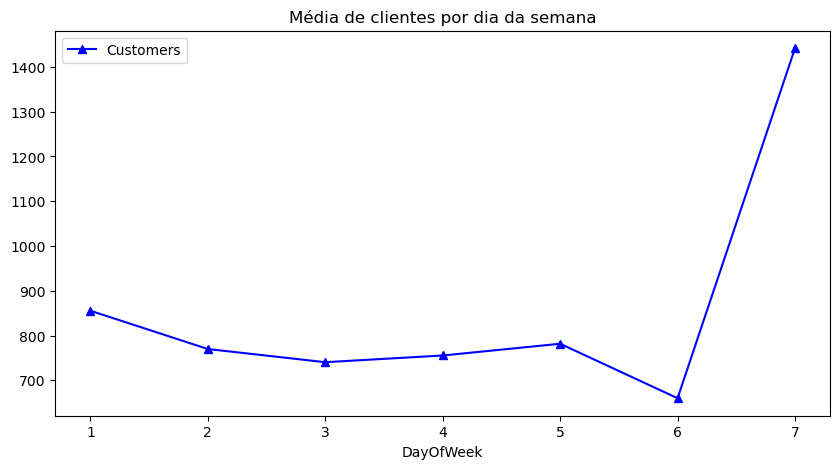

In [58]:
axis = sales_train_all_df.groupby('DayOfWeek')[['Customers']].mean().plot(figsize = (10,5), marker = '^', color = 'b')
axis.set_title('Média de clientes por dia da semana')

<AxesSubplot:xlabel='Date'>

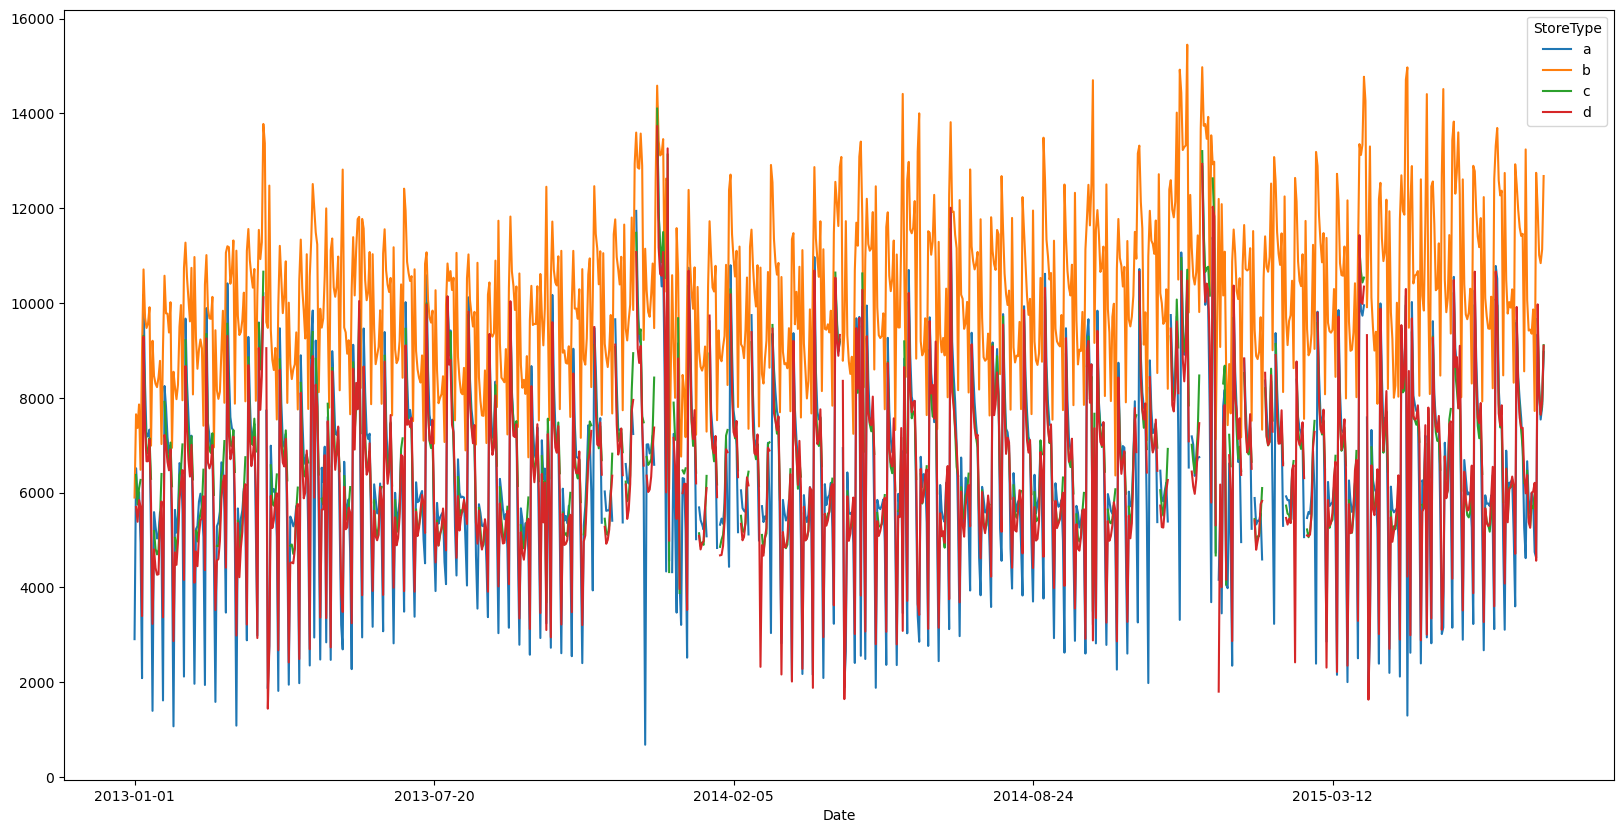

In [59]:
fig, ax = plt.subplots(figsize = (20,10))
sales_train_all_df.groupby(['Date', 'StoreType']).mean()['Sales'].unstack().plot(ax = ax)

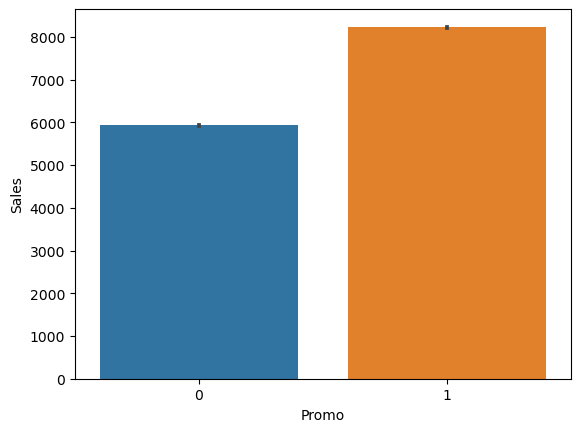

In [60]:
sns.barplot(x = 'Promo', y = 'Sales', data = sales_train_all_df);

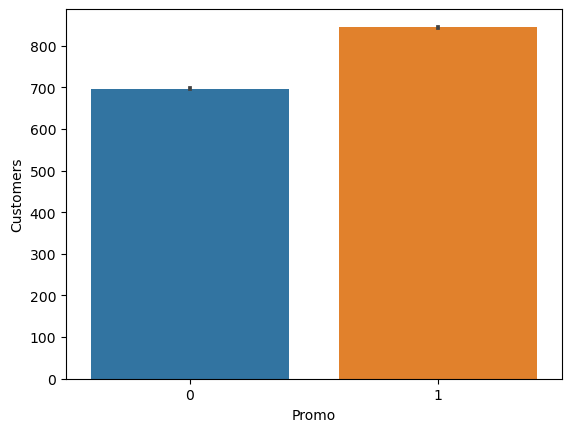

In [61]:
sns.barplot(x = 'Promo', y = 'Customers', data = sales_train_all_df);

## Treinamento do modelo - parte 1

In [62]:
sales_train_all_df

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
844387,292,1,2013-01-07,9291,1002,1,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,7
844388,292,6,2013-01-05,2748,340,0,0,0,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,5
844389,292,5,2013-01-04,4202,560,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,4
844390,292,4,2013-01-03,4580,662,0,0,1,a,a,1100.0,6.0,2009.0,0,0.0,0.0,0,2013,1,3


In [63]:
# Função de predição do prophet
# Função que fará a predição de apenas uma loja
def sales_prediction(loja, df, dias):
    # Filtra loja específica
    df = df[df['Store'] == loja]
    # Renomeia colunas de data e rótulo para ds e y, respectivamente, exigência do prophet
    df = df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales':'y'})
    # Ordenamos pela data
    df = df.sort_values(by = 'ds')
    # Instanciamos o modelo e fazemos o treinamento
    model = Prophet()
    model.fit(df)
    # Future é a series com os dias que estamos prevendo
    future = model.make_future_dataframe(periods = dias)
    print('Future : ')
    print(future)
    # Forecast já é o dataframe resultado da predição do prophet
    # yhat é o valor previsto e há outras variáveis com limites mínimos e máximos 
    forecast = model.predict(future)
    print('Forecast : ')
    print(forecast)
    # model.plot plotará o resultado do forecasting
    figure1 = model.plot(forecast, xlabel = 'Data', ylabel = 'Vendas')
    # plot_components mostrará outros itens do modelo, como tendência pela série, evolução semanal, anual, etc
    figure2 = model.plot_components(forecast)
    
    return df, forecast

10:49:48 - cmdstanpy - INFO - Chain [1] start processing
10:49:48 - cmdstanpy - INFO - Chain [1] done processing


Future : 
            ds
0   2013-01-02
1   2013-01-03
2   2013-01-04
3   2013-01-05
4   2013-01-07
..         ...
839 2015-09-25
840 2015-09-26
841 2015-09-27
842 2015-09-28
843 2015-09-29

[844 rows x 1 columns]
Forecast : 
            ds        trend   yhat_lower   yhat_upper  trend_lower  \
0   2013-01-02  5205.640272  4078.076193  6182.516726  5205.640272   
1   2013-01-03  5206.380914  4107.507866  6160.680764  5206.380914   
2   2013-01-04  5207.121555  4332.907767  6375.408164  5207.121555   
3   2013-01-05  5207.862197  3403.625245  5541.740905  5207.862197   
4   2013-01-07  5209.343480  5024.969046  7146.578860  5209.343480   
..         ...          ...          ...          ...          ...   
839 2015-09-25  5943.363513  4902.981981  7012.843173  5943.363391   
840 2015-09-26  5944.104217  4190.233018  6259.348662  5944.104089   
841 2015-09-27  5944.844921  4688.178017  6904.913325  5944.844789   
842 2015-09-28  5945.585625  6003.796333  8113.353068  5945.585490   
843 

(              ds     y
 7819  2013-01-02  4812
 7818  2013-01-03  4675
 7817  2013-01-04  5114
 7816  2013-01-05  4256
 7815  2013-01-07  7804
 ...          ...   ...
 7040  2015-07-27  7212
 7039  2015-07-28  6140
 7038  2015-07-29  5524
 7037  2015-07-30  6186
 7036  2015-07-31  7185
 
 [784 rows x 2 columns],
             ds        trend   yhat_lower   yhat_upper  trend_lower  \
 0   2013-01-02  5205.640272  4078.076193  6182.516726  5205.640272   
 1   2013-01-03  5206.380914  4107.507866  6160.680764  5206.380914   
 2   2013-01-04  5207.121555  4332.907767  6375.408164  5207.121555   
 3   2013-01-05  5207.862197  3403.625245  5541.740905  5207.862197   
 4   2013-01-07  5209.343480  5024.969046  7146.578860  5209.343480   
 ..         ...          ...          ...          ...          ...   
 839 2015-09-25  5943.363513  4902.981981  7012.843173  5943.363391   
 840 2015-09-26  5944.104217  4190.233018  6259.348662  5944.104089   
 841 2015-09-27  5944.844921  4688.178017  690

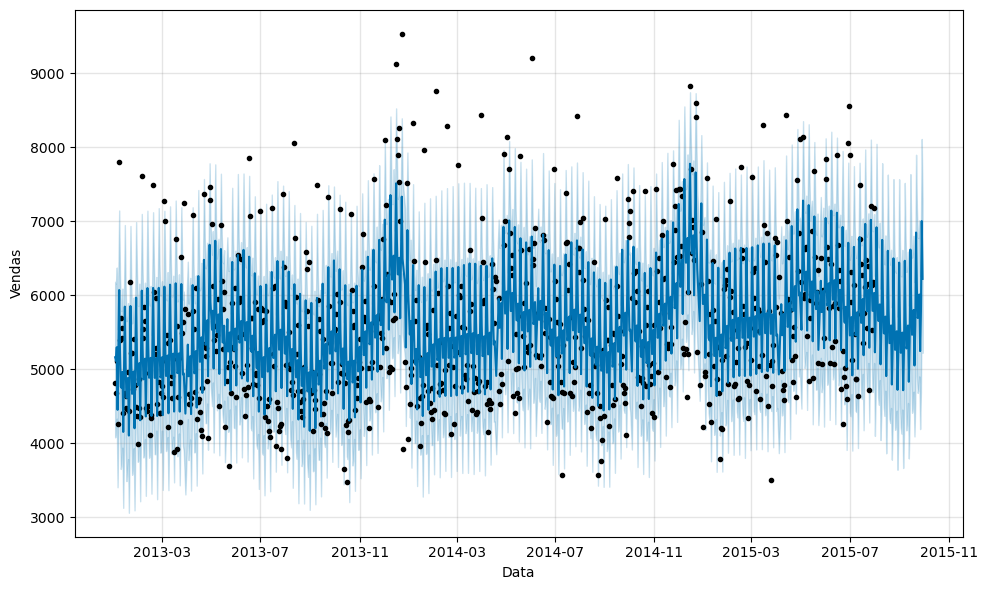

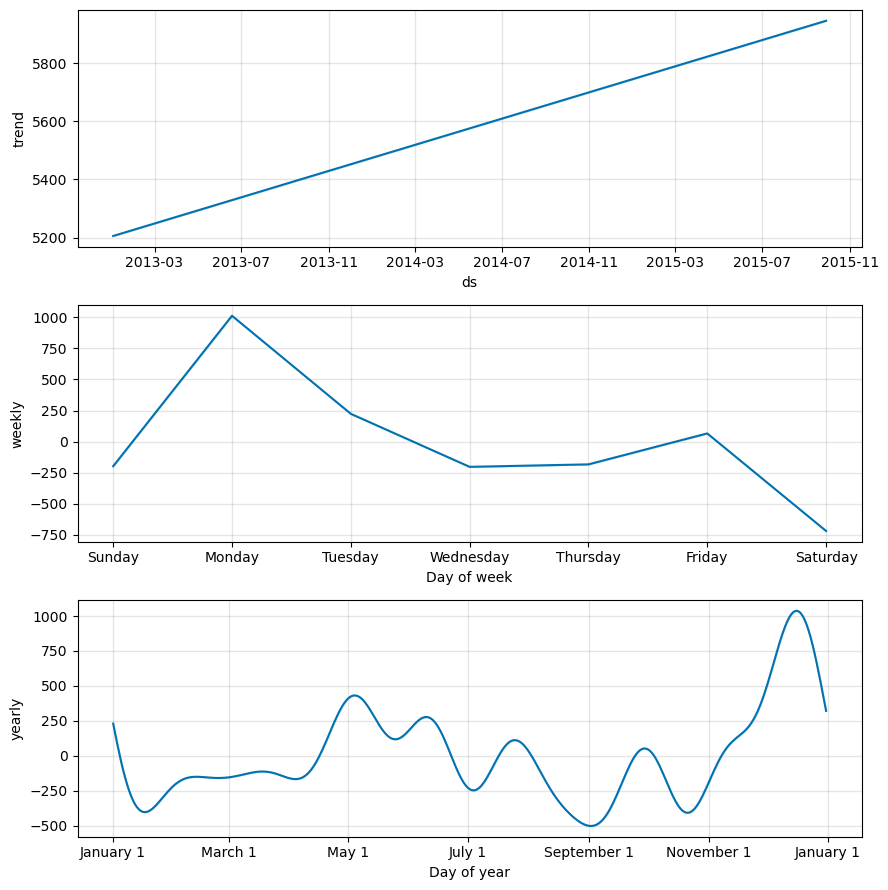

In [64]:
df = sales_prediction(10, sales_train_all_df, 60)
df

10:49:49 - cmdstanpy - INFO - Chain [1] start processing
10:49:49 - cmdstanpy - INFO - Chain [1] done processing


Future : 
            ds
0   2013-01-02
1   2013-01-03
2   2013-01-04
3   2013-01-05
4   2013-01-07
..         ...
839 2015-09-25
840 2015-09-26
841 2015-09-27
842 2015-09-28
843 2015-09-29

[844 rows x 1 columns]
Forecast : 
            ds        trend   yhat_lower   yhat_upper  trend_lower  \
0   2013-01-02  5205.640272  4069.657228  6160.407531  5205.640272   
1   2013-01-03  5206.380914  4084.073791  6174.023748  5206.380914   
2   2013-01-04  5207.121555  4261.996196  6391.124103  5207.121555   
3   2013-01-05  5207.862197  3438.056394  5460.543623  5207.862197   
4   2013-01-07  5209.343480  4991.414361  7086.211124  5209.343480   
..         ...          ...          ...          ...          ...   
839 2015-09-25  5943.363513  4950.321964  7016.948396  5943.363334   
840 2015-09-26  5944.104217  4177.471441  6304.728453  5944.104035   
841 2015-09-27  5944.844921  4751.993261  6764.868538  5944.844734   
842 2015-09-28  5945.585625  5969.671719  8043.656987  5945.585434   
843 

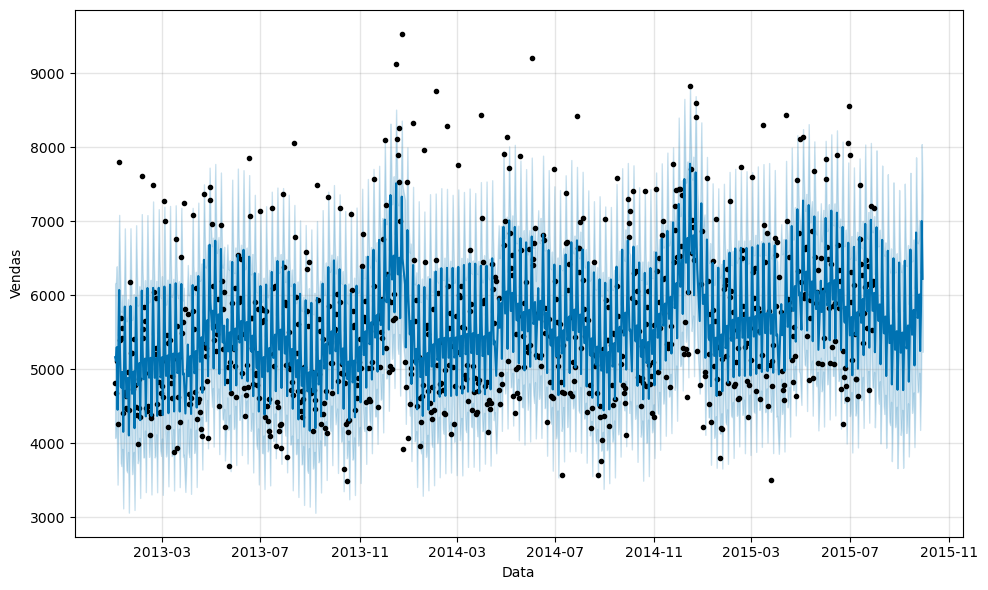

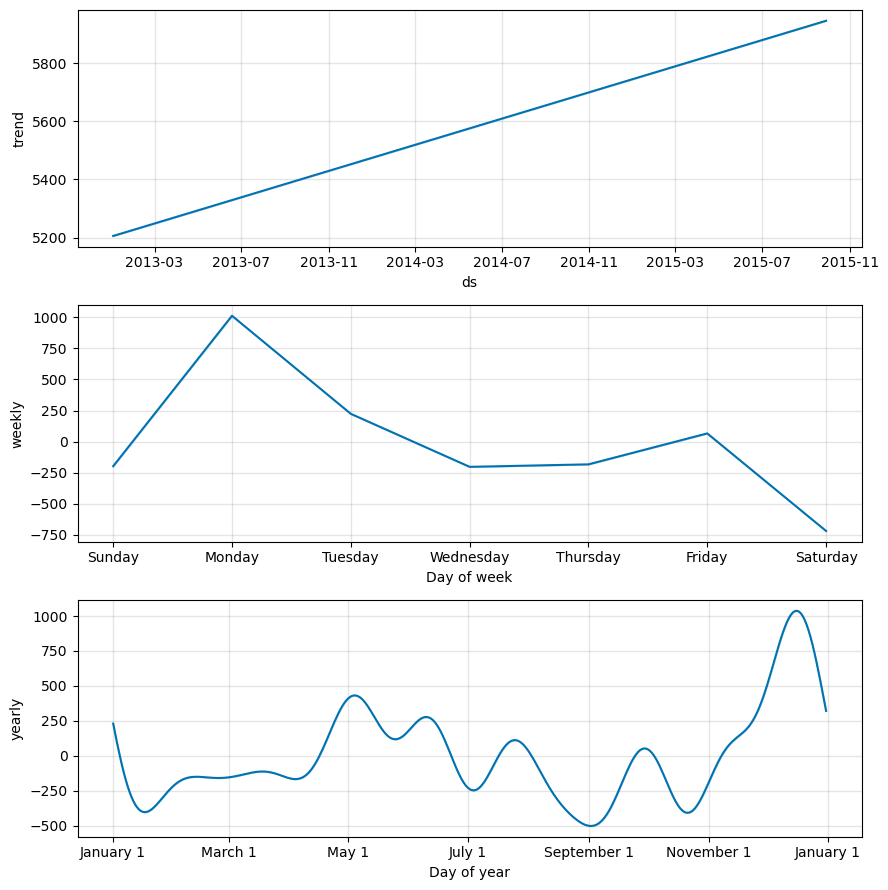

In [65]:
df_origin, df_prediction = sales_prediction(10, sales_train_all_df, 60)

In [66]:
df

(              ds     y
 7819  2013-01-02  4812
 7818  2013-01-03  4675
 7817  2013-01-04  5114
 7816  2013-01-05  4256
 7815  2013-01-07  7804
 ...          ...   ...
 7040  2015-07-27  7212
 7039  2015-07-28  6140
 7038  2015-07-29  5524
 7037  2015-07-30  6186
 7036  2015-07-31  7185
 
 [784 rows x 2 columns],
             ds        trend   yhat_lower   yhat_upper  trend_lower  \
 0   2013-01-02  5205.640272  4078.076193  6182.516726  5205.640272   
 1   2013-01-03  5206.380914  4107.507866  6160.680764  5206.380914   
 2   2013-01-04  5207.121555  4332.907767  6375.408164  5207.121555   
 3   2013-01-05  5207.862197  3403.625245  5541.740905  5207.862197   
 4   2013-01-07  5209.343480  5024.969046  7146.578860  5209.343480   
 ..         ...          ...          ...          ...          ...   
 839 2015-09-25  5943.363513  4902.981981  7012.843173  5943.363391   
 840 2015-09-26  5944.104217  4190.233018  6259.348662  5944.104089   
 841 2015-09-27  5944.844921  4688.178017  690

In [67]:
(df_origin.shape, df_prediction.shape)

((784, 2), (844, 19))

In [68]:
784-844

-60

In [69]:
df_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5205.640272,4069.657228,6160.407531,5205.640272,5205.640272,-43.613074,-43.613074,-43.613074,-202.897975,-202.897975,-202.897975,159.284901,159.284901,159.284901,0.0,0.0,0.0,5162.027198
1,2013-01-03,5206.380914,4084.073791,6174.023748,5206.380914,5206.380914,-92.796677,-92.796677,-92.796677,-182.947926,-182.947926,-182.947926,90.151249,90.151249,90.151249,0.0,0.0,0.0,5113.584237
2,2013-01-04,5207.121555,4261.996196,6391.124103,5207.121555,5207.121555,89.971687,89.971687,89.971687,66.016348,66.016348,66.016348,23.955340,23.955340,23.955340,0.0,0.0,0.0,5297.093243
3,2013-01-05,5207.862197,3438.056394,5460.543623,5207.862197,5207.862197,-757.559402,-757.559402,-757.559402,-718.884996,-718.884996,-718.884996,-38.674406,-38.674406,-38.674406,0.0,0.0,0.0,4450.302795
4,2013-01-07,5209.343480,4991.414361,7086.211124,5209.343480,5209.343480,861.737942,861.737942,861.737942,1012.863827,1012.863827,1012.863827,-151.125886,-151.125886,-151.125886,0.0,0.0,0.0,6071.081422


In [70]:
df_prediction.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
839,2015-09-25,5943.363513,4950.321964,7016.948396,5943.363334,5943.363675,67.172563,67.172563,67.172563,66.016348,66.016348,66.016348,1.156215,1.156215,1.156215,0.0,0.0,0.0,6010.536076
840,2015-09-26,5944.104217,4177.471441,6304.728453,5944.104035,5944.104382,-698.946145,-698.946145,-698.946145,-718.884996,-718.884996,-718.884996,19.938851,19.938851,19.938851,0.0,0.0,0.0,5245.158072
841,2015-09-27,5944.844921,4751.993261,6764.868538,5944.844734,5944.845094,-163.167367,-163.167367,-163.167367,-197.965470,-197.965470,-197.965470,34.798102,34.798102,34.798102,0.0,0.0,0.0,5781.677554
842,2015-09-28,5945.585625,5969.671719,8043.656987,5945.585434,5945.585803,1058.290012,1058.290012,1058.290012,1012.863827,1012.863827,1012.863827,45.426185,45.426185,45.426185,0.0,0.0,0.0,7003.875637
843,2015-09-29,5946.326330,5235.167900,7349.974465,5946.326132,5946.326510,275.409767,275.409767,275.409767,223.816191,223.816191,223.816191,51.593576,51.593576,51.593576,0.0,0.0,0.0,6221.736097


In [71]:
df_prediction.tail(60).to_csv('previsoes_vendas_loja10.csv')

In [72]:
df_origin.tail()

,ds,y
7040,2015-07-27,7212
7039,2015-07-28,6140
7038,2015-07-29,5524
7037,2015-07-30,6186
7036,2015-07-31,7185


## Treinamento do modelo - parte 2


   - StateHoliday: Normalmente todas as lojas estão fechadas nesses feriados. As escolas estão fechadas nesses feriados e nos finais de semana. Legenda: a = public holiday, b = Páscoa, c = Natal, 0 = Nenhum feriado
   - SchoolHoliday: indica se a loja foi afetada pelo feriado escolar
  






In [73]:
sales_train_all_df[['Date', 'Sales']]

,Date,Sales
0,2015-07-31,5263
1,2015-07-30,5020
2,2015-07-29,4782
3,2015-07-28,5011
4,2015-07-27,6102
...,...,...
844387,2013-01-07,9291
844388,2013-01-05,2748
844389,2013-01-04,4202
844390,2013-01-03,4580


In [74]:
# Função para predição da venda considerando feriados

def sales_prediction(store, df, holidays, periods):
    df = df[df['Store'] == store]
    df = df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    df.sort_values(by = 'ds', inplace=True)
    # A diferença está aqui, em que passamos os feriados
    # esta variável pode conter não somente dias de baixo movimento, mas também dias especiais, como blackfriday e aniversários de empresa
    # Pode conter lower_window e upper_window com qtd de dias de influência da data especial
    # vide doc: https://facebook.github.io/prophet/docs/seasonality,_holiday_effects,_and_regressors.html#modeling-holidays-and-special-events
    model = Prophet(holidays=holidays)
    model.fit(df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    figure1 = model.plot(forecast, xlabel='Data', ylabel = 'Vendas')
    figure2 = model.plot_components(forecast)
    
    return df, forecast

In [75]:
sales_train_all_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,31
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,30
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,29
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,28
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,0,2015,7,27


In [76]:
school_holidays = sales_train_all_df[sales_train_all_df['SchoolHoliday']==1].loc[:, 'Date'].values
school_holidays.shape

(163457,)

In [77]:
school_holidays

array(['2015-07-31', '2015-07-30', '2015-07-29', ..., '2013-01-04',
       '2013-01-03', '2013-01-02'], dtype=object)

In [78]:
len(np.unique(school_holidays))

477

In [79]:
state_holidays = sales_train_all_df[(sales_train_all_df['StateHoliday'] == 'a') | 
                                    (sales_train_all_df['StateHoliday'] == 'b') |
                                    (sales_train_all_df['StateHoliday'] == 'c')].loc[:,'Date'].values

In [80]:
state_holidays

array(['2014-10-03', '2013-10-03', '2015-06-04', '2014-06-19',
       '2013-05-30', '2015-06-04', '2014-06-19', '2013-05-30',
       '2014-10-03', '2013-10-03', '2015-05-01', '2014-10-31',
       '2014-05-01', '2013-10-03', '2013-05-01', '2015-06-04',
       '2014-06-19', '2013-05-30', '2015-06-04', '2014-06-19',
       '2013-05-30', '2013-08-15', '2015-06-04', '2014-06-19',
       '2013-05-30', '2013-08-15', '2013-08-15', '2015-05-25',
       '2015-05-14', '2015-05-01', '2015-04-06', '2015-04-03',
       '2015-01-01', '2014-12-26', '2014-12-25', '2014-10-03',
       '2014-06-09', '2014-05-29', '2014-05-01', '2014-04-21',
       '2014-04-18', '2014-01-01', '2013-12-26', '2013-12-25',
       '2013-10-03', '2013-05-20', '2013-05-09', '2013-05-01',
       '2013-04-01', '2013-03-29', '2013-01-01', '2014-10-03',
       '2015-06-04', '2014-06-19', '2013-05-30', '2015-06-04',
       '2014-06-19', '2013-05-30', '2015-06-04', '2014-06-19',
       '2013-05-30', '2013-10-03', '2014-10-03', '2013-

In [81]:
state_holidays.shape

(910,)

In [82]:
len(np.unique(state_holidays))

35

In [83]:
state_holidays = pd.DataFrame({'ds': pd.to_datetime(state_holidays),
                              'holiday': 'state_holiday'})
state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
905,2013-04-01,state_holiday
906,2013-08-15,state_holiday
907,2015-06-04,state_holiday
908,2014-06-19,state_holiday


In [84]:
school_holidays = pd.DataFrame({'ds': pd.to_datetime(school_holidays),
                               'holiday': 'school_holiday'})
school_holidays

,ds,holiday
0,2015-07-31,school_holiday
1,2015-07-30,school_holiday
2,2015-07-29,school_holiday
3,2015-07-28,school_holiday
4,2015-07-27,school_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


In [85]:
school_state_holidays = pd.concat((state_holidays, school_holidays))
school_state_holidays

,ds,holiday
0,2014-10-03,state_holiday
1,2013-10-03,state_holiday
2,2015-06-04,state_holiday
3,2014-06-19,state_holiday
4,2013-05-30,state_holiday
...,...,...
163452,2013-02-05,school_holiday
163453,2013-02-04,school_holiday
163454,2013-01-04,school_holiday
163455,2013-01-03,school_holiday


10:49:56 - cmdstanpy - INFO - Chain [1] start processing
10:49:56 - cmdstanpy - INFO - Chain [1] done processing


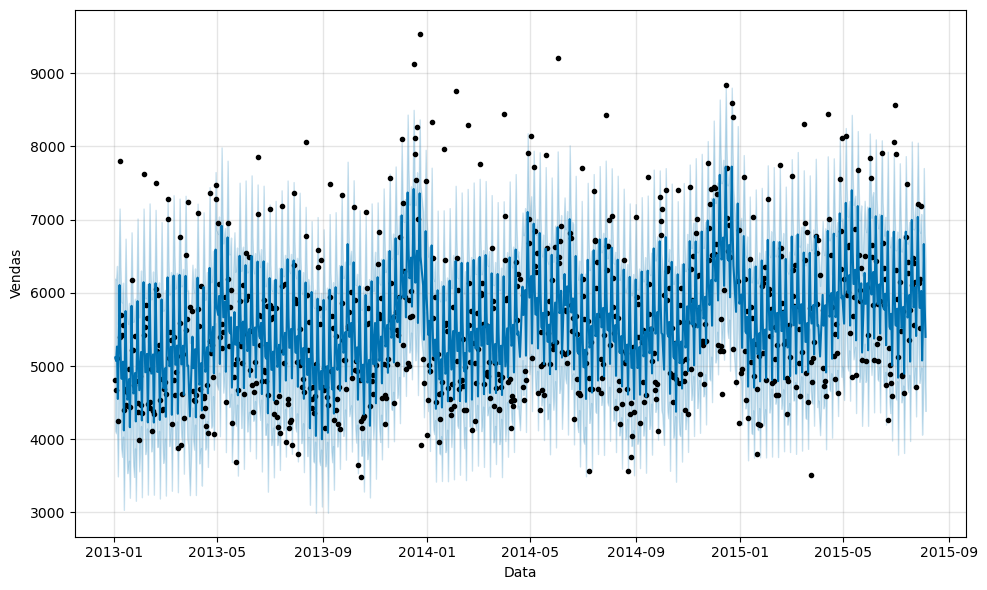

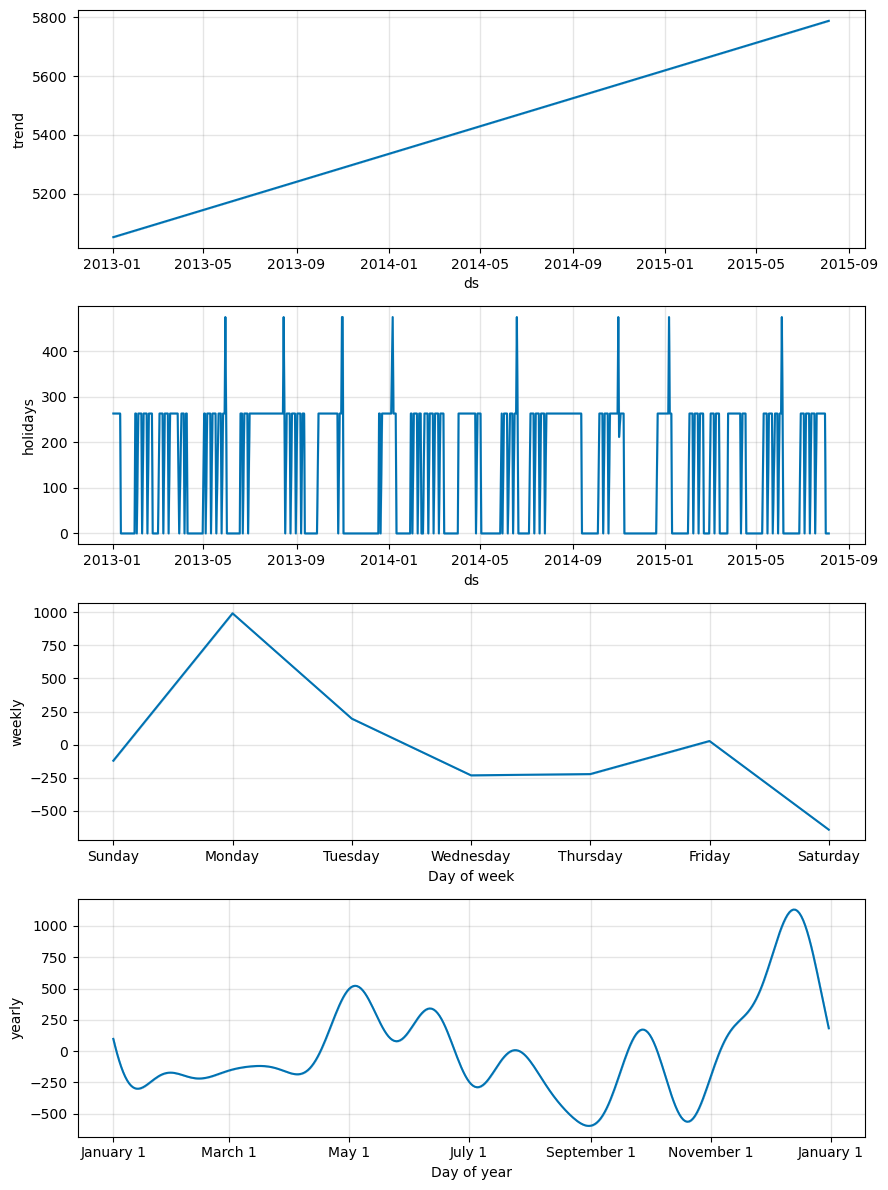

In [86]:
df_original, df_prediction = sales_prediction(10, sales_train_all_df, school_state_holidays, 5)

In [87]:
df_prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2013-01-02,5051.494560,4112.726524,6194.361072,5051.494560,5051.494560,65.539714,65.539714,65.539714,263.243274,...,-231.247978,-231.247978,-231.247978,33.544418,33.544418,33.544418,0.0,0.0,0.0,5117.034274
1,2013-01-03,5052.275247,4081.887923,6184.908389,5052.275247,5052.275247,16.422377,16.422377,16.422377,263.243274,...,-221.737958,-221.737958,-221.737958,-25.082939,-25.082939,-25.082939,0.0,0.0,0.0,5068.697624
2,2013-01-04,5053.055933,4258.480125,6366.649796,5053.055933,5053.055933,212.434775,212.434775,212.434775,263.243274,...,27.642505,27.642505,27.642505,-78.451004,-78.451004,-78.451004,0.0,0.0,0.0,5265.490708
3,2013-01-05,5053.836620,3493.148863,5575.285931,5053.836620,5053.836620,-503.775726,-503.775726,-503.775726,263.243274,...,-640.817534,-640.817534,-640.817534,-126.201466,-126.201466,-126.201466,0.0,0.0,0.0,4550.060893
4,2013-01-07,5055.397993,5108.066593,7150.054956,5055.397993,5055.397993,1049.812563,1049.812563,1049.812563,263.243274,...,990.585850,990.585850,990.585850,-204.016561,-204.016561,-204.016561,0.0,0.0,0.0,6105.210556


In [88]:
df_prediction.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'holidays', 'holidays_lower', 'holidays_upper', 'school_holiday',
       'school_holiday_lower', 'school_holiday_upper', 'state_holiday',
       'state_holiday_lower', 'state_holiday_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [89]:
df_prediction.shape

(789, 28)

#  Criando meu modelo para todas as lojas

In [90]:
np.unique(sales_train_all_df['Store'])

array([   1,    2,    3, ..., 1113, 1114, 1115], dtype=int64)

In [91]:
# Função para predição da venda considerando feriados

def sales_prediction(store, df, holidays, periods):
    df = df[df['Store'] == store]
    df = df[['Date', 'Sales']].rename(columns = {'Date': 'ds', 'Sales': 'y'})
    #df.sort_values(by = 'ds', inplace=True)
    model = Prophet(holidays=holidays)
    model.fit(df)
    future = model.make_future_dataframe(periods = periods)
    forecast = model.predict(future)
    #figure1 = model.plot(forecast, xlabel='Data', ylabel = 'Vendas')
    #figure2 = model.plot_components(forecast)
    
    return forecast

In [94]:
def sales_prediction_all(df, holidays, periods):
    #stores = np.unique(df['Store'])
    # Marretando as lojas para testes
    stores = [1,3,10]
    for store in stores:
        df_store = sales_prediction(store,df, holidays, periods)
        df_store['Store'] = store
        if store == stores[0]:
            df_all = df_store
        else:
            df_all = pd.concat([df_all,df_store])
    
    return df_all
        
        
    

In [95]:
previsoes = sales_prediction_all(sales_train_all_df, school_state_holidays, 5)

10:50:25 - cmdstanpy - INFO - Chain [1] start processing
10:50:25 - cmdstanpy - INFO - Chain [1] done processing
10:50:42 - cmdstanpy - INFO - Chain [1] start processing
10:50:42 - cmdstanpy - INFO - Chain [1] done processing
10:50:59 - cmdstanpy - INFO - Chain [1] start processing
10:50:59 - cmdstanpy - INFO - Chain [1] done processing


In [96]:
previsoes

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Store
0,2013-01-02,4982.781936,4321.495415,6497.325378,4982.781936,4982.781936,497.219400,497.219400,497.219400,416.259264,...,-265.777885,-265.777885,346.738021,346.738021,346.738021,0.0,0.0,0.0,5480.001336,1
1,2013-01-03,4981.499275,4077.952298,6386.827488,4981.499275,4981.499275,288.822409,288.822409,288.822409,416.259264,...,-362.092916,-362.092916,234.656061,234.656061,234.656061,0.0,0.0,0.0,5270.321684,1
2,2013-01-04,4980.216613,4377.134781,6471.625290,4980.216613,4980.216613,428.735566,428.735566,428.735566,416.259264,...,-119.294627,-119.294627,131.770929,131.770929,131.770929,0.0,0.0,0.0,5408.952179,1
3,2013-01-05,4978.933952,4666.209849,6723.210450,4978.933952,4978.933952,728.480956,728.480956,728.480956,416.259264,...,273.127349,273.127349,39.094343,39.094343,39.094343,0.0,0.0,0.0,5707.414907,1
4,2013-01-07,4976.368629,4555.489479,6707.743836,4976.368629,4976.368629,653.315574,653.315574,653.315574,416.259264,...,349.763058,349.763058,-112.706748,-112.706748,-112.706748,0.0,0.0,0.0,5629.684203,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2015-08-01,5785.527189,4072.499824,6133.112356,5785.527189,5785.527189,-710.232034,-710.232034,-710.232034,0.000000,...,-640.817534,-640.817534,-69.414500,-69.414500,-69.414500,0.0,0.0,0.0,5075.295155,10
785,2015-08-02,5786.307228,4523.039269,6611.681526,5786.307228,5786.307228,-210.956907,-210.956907,-210.956907,0.000000,...,-120.846524,-120.846524,-90.110384,-90.110384,-90.110384,0.0,0.0,0.0,5575.350320,10
786,2015-08-03,5787.087266,5680.236273,7762.998240,5787.087266,5787.087266,878.312305,878.312305,878.312305,0.000000,...,990.585850,990.585850,-112.273545,-112.273545,-112.273545,0.0,0.0,0.0,6665.399571,10
787,2015-08-04,5787.867304,4800.607351,6835.386356,5787.867304,5787.867304,60.867251,60.867251,60.867251,0.000000,...,196.421639,196.421639,-135.554388,-135.554388,-135.554388,0.0,0.0,0.0,5848.734555,10


In [97]:
df_teste = sales_train_all_df[['Date','Store', 'Sales']][sales_train_all_df['Store'].isin(stores)].rename(columns = {'Date': 'ds'})
df_teste['ds'] = pd.DatetimeIndex(df_teste['ds'])
df_teste

,ds,Store,Sales
0,2015-07-31,1,5263
1,2015-07-30,1,5020
2,2015-07-29,1,4782
3,2015-07-28,1,5011
4,2015-07-27,1,6102
...,...,...,...
7815,2013-01-07,10,7804
7816,2013-01-05,10,4256
7817,2013-01-04,10,5114
7818,2013-01-03,10,4675


In [98]:
teste = pd.merge(previsoes,df_teste,on=['ds','Store'], how="left")
teste

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Store,Sales
0,2013-01-02,4982.781936,4321.495415,6497.325378,4982.781936,4982.781936,497.219400,497.219400,497.219400,416.259264,...,-265.777885,346.738021,346.738021,346.738021,0.0,0.0,0.0,5480.001336,1,5530.0
1,2013-01-03,4981.499275,4077.952298,6386.827488,4981.499275,4981.499275,288.822409,288.822409,288.822409,416.259264,...,-362.092916,234.656061,234.656061,234.656061,0.0,0.0,0.0,5270.321684,1,4327.0
2,2013-01-04,4980.216613,4377.134781,6471.625290,4980.216613,4980.216613,428.735566,428.735566,428.735566,416.259264,...,-119.294627,131.770929,131.770929,131.770929,0.0,0.0,0.0,5408.952179,1,4486.0
3,2013-01-05,4978.933952,4666.209849,6723.210450,4978.933952,4978.933952,728.480956,728.480956,728.480956,416.259264,...,273.127349,39.094343,39.094343,39.094343,0.0,0.0,0.0,5707.414907,1,4997.0
4,2013-01-07,4976.368629,4555.489479,6707.743836,4976.368629,4976.368629,653.315574,653.315574,653.315574,416.259264,...,349.763058,-112.706748,-112.706748,-112.706748,0.0,0.0,0.0,5629.684203,1,7176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2354,2015-08-01,5785.527189,4072.499824,6133.112356,5785.527189,5785.527189,-710.232034,-710.232034,-710.232034,0.000000,...,-640.817534,-69.414500,-69.414500,-69.414500,0.0,0.0,0.0,5075.295155,10,NaN
2355,2015-08-02,5786.307228,4523.039269,6611.681526,5786.307228,5786.307228,-210.956907,-210.956907,-210.956907,0.000000,...,-120.846524,-90.110384,-90.110384,-90.110384,0.0,0.0,0.0,5575.350320,10,NaN
2356,2015-08-03,5787.087266,5680.236273,7762.998240,5787.087266,5787.087266,878.312305,878.312305,878.312305,0.000000,...,990.585850,-112.273545,-112.273545,-112.273545,0.0,0.0,0.0,6665.399571,10,NaN
2357,2015-08-04,5787.867304,4800.607351,6835.386356,5787.867304,5787.867304,60.867251,60.867251,60.867251,0.000000,...,196.421639,-135.554388,-135.554388,-135.554388,0.0,0.0,0.0,5848.734555,10,NaN


In [99]:
teste = teste[teste['Sales'].notnull()]
teste

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Store,Sales
0,2013-01-02,4982.781936,4321.495415,6497.325378,4982.781936,4982.781936,497.219400,497.219400,497.219400,416.259264,...,-265.777885,346.738021,346.738021,346.738021,0.0,0.0,0.0,5480.001336,1,5530.0
1,2013-01-03,4981.499275,4077.952298,6386.827488,4981.499275,4981.499275,288.822409,288.822409,288.822409,416.259264,...,-362.092916,234.656061,234.656061,234.656061,0.0,0.0,0.0,5270.321684,1,4327.0
2,2013-01-04,4980.216613,4377.134781,6471.625290,4980.216613,4980.216613,428.735566,428.735566,428.735566,416.259264,...,-119.294627,131.770929,131.770929,131.770929,0.0,0.0,0.0,5408.952179,1,4486.0
3,2013-01-05,4978.933952,4666.209849,6723.210450,4978.933952,4978.933952,728.480956,728.480956,728.480956,416.259264,...,273.127349,39.094343,39.094343,39.094343,0.0,0.0,0.0,5707.414907,1,4997.0
4,2013-01-07,4976.368629,4555.489479,6707.743836,4976.368629,4976.368629,653.315574,653.315574,653.315574,416.259264,...,349.763058,-112.706748,-112.706748,-112.706748,0.0,0.0,0.0,5629.684203,1,7176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2349,2015-07-27,5781.626998,6012.176146,8048.847148,5781.626998,5781.626998,1254.014896,1254.014896,1254.014896,263.243274,...,990.585850,0.185772,0.185772,0.185772,0.0,0.0,0.0,7035.641894,10,7212.0
2350,2015-07-28,5782.407036,5202.638865,7270.032278,5782.407036,5782.407036,451.476766,451.476766,451.476766,263.243274,...,196.421639,-8.188147,-8.188147,-8.188147,0.0,0.0,0.0,6233.883802,10,6140.0
2351,2015-07-29,5783.187074,4792.658201,6928.516935,5783.187074,5783.187074,12.382777,12.382777,12.382777,263.243274,...,-231.247978,-19.612519,-19.612519,-19.612519,0.0,0.0,0.0,5795.569852,10,5524.0
2352,2015-07-30,5783.967113,4707.006174,6854.817207,5783.967113,5783.967113,7.676430,7.676430,7.676430,263.243274,...,-221.737958,-33.828886,-33.828886,-33.828886,0.0,0.0,0.0,5791.643542,10,6186.0


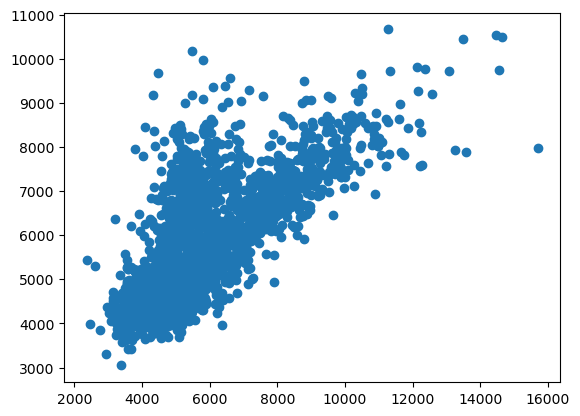

In [100]:
plt.scatter(teste['Sales'], teste['yhat'])

C:\Users\nicol\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


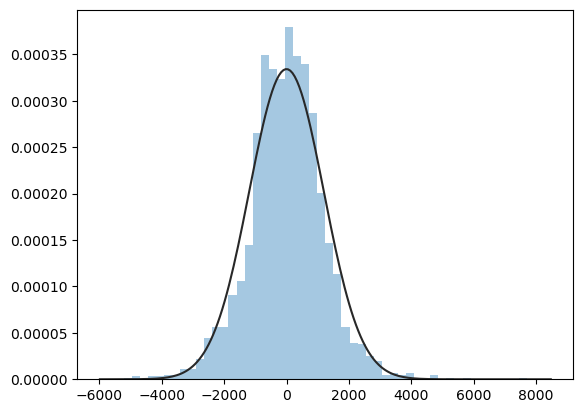

In [101]:
# Histograma residual
sns.distplot((teste['Sales']-teste['yhat']),bins=50,fit=norm, kde=False);

In [102]:
# Precisamos entender primeiro é calculado analisando o quanto os valores previstos se distanciaram dos valores reais. 
# Ou seja, é o absoluto de (previstos-classe_teste)
# As principais métricas de desempenho para regressão são:
# MAE: Média dos erros absolutos
print('MAE:', metrics.mean_absolute_error(teste['Sales'], teste['yhat']))
# Média dos erros quadrados. Quanto maior o erro, maior seu quadrado e pune mais os erros maiores
print('MSE:', metrics.mean_squared_error(teste['Sales'], teste['yhat']))
# Raiz quadrada da média dos erros quadrados. Mais popular
print('RMSE:', np.sqrt(metrics.mean_squared_error(teste['Sales'], teste['yhat'])))

MAE: 907.5615352447055
MSE: 1426050.0130367891
RMSE: 1194.173359708208


In [103]:
previsoes

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,Store
0,2013-01-02,4982.781936,4321.495415,6497.325378,4982.781936,4982.781936,497.219400,497.219400,497.219400,416.259264,...,-265.777885,-265.777885,346.738021,346.738021,346.738021,0.0,0.0,0.0,5480.001336,1
1,2013-01-03,4981.499275,4077.952298,6386.827488,4981.499275,4981.499275,288.822409,288.822409,288.822409,416.259264,...,-362.092916,-362.092916,234.656061,234.656061,234.656061,0.0,0.0,0.0,5270.321684,1
2,2013-01-04,4980.216613,4377.134781,6471.625290,4980.216613,4980.216613,428.735566,428.735566,428.735566,416.259264,...,-119.294627,-119.294627,131.770929,131.770929,131.770929,0.0,0.0,0.0,5408.952179,1
3,2013-01-05,4978.933952,4666.209849,6723.210450,4978.933952,4978.933952,728.480956,728.480956,728.480956,416.259264,...,273.127349,273.127349,39.094343,39.094343,39.094343,0.0,0.0,0.0,5707.414907,1
4,2013-01-07,4976.368629,4555.489479,6707.743836,4976.368629,4976.368629,653.315574,653.315574,653.315574,416.259264,...,349.763058,349.763058,-112.706748,-112.706748,-112.706748,0.0,0.0,0.0,5629.684203,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
784,2015-08-01,5785.527189,4072.499824,6133.112356,5785.527189,5785.527189,-710.232034,-710.232034,-710.232034,0.000000,...,-640.817534,-640.817534,-69.414500,-69.414500,-69.414500,0.0,0.0,0.0,5075.295155,10
785,2015-08-02,5786.307228,4523.039269,6611.681526,5786.307228,5786.307228,-210.956907,-210.956907,-210.956907,0.000000,...,-120.846524,-120.846524,-90.110384,-90.110384,-90.110384,0.0,0.0,0.0,5575.350320,10
786,2015-08-03,5787.087266,5680.236273,7762.998240,5787.087266,5787.087266,878.312305,878.312305,878.312305,0.000000,...,990.585850,990.585850,-112.273545,-112.273545,-112.273545,0.0,0.0,0.0,6665.399571,10
787,2015-08-04,5787.867304,4800.607351,6835.386356,5787.867304,5787.867304,60.867251,60.867251,60.867251,0.000000,...,196.421639,196.421639,-135.554388,-135.554388,-135.554388,0.0,0.0,0.0,5848.734555,10
